# IBM Streams Event Streams sample application

This sample demonstrates how to create a Streams Python application that ingests data into the [IBM Event Streams](https://cloud.ibm.com/catalog?search=Event%20Streams) service, and consumes the data from Event Streams. The IBM Event Streams service is a fully managed Kafka Service within the IBM cloud.

In this notebook, you'll see examples of how to :
 1. [Setup your data connections](#setup)
 2. [Create the application](#create)
 3. [Submit the application](#launch)
 4. [Connect to the running application to view data](#view)
 5. [Stop the application](#cancel)

# Overview

**About the sample**

This application creates artificial sensor data and writes them into a topic in the IBM Event Streams instance, subscribes to the same topic and filters out the data of one sensor.

**How it works**

The Python application created in this notebook is submitted to the IBM Streams service for execution. Once the application is running in the service, you can connect to it from the notebook to retrieve the results.

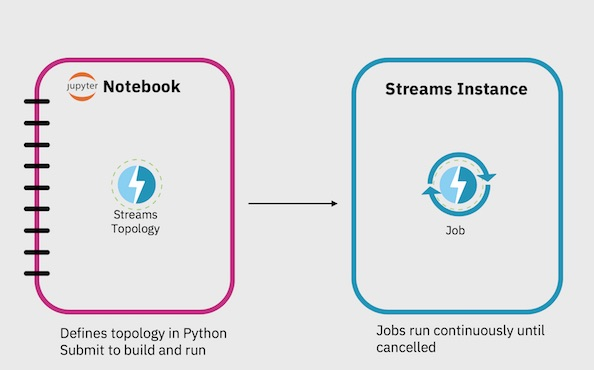


### Documentation

- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)



<a name="setup"></a>
# 1. Setup
### 1.1 Add credentials for the IBM Streams service

In order to submit a Streams application you need to provide the name of the Streams instance.

1. From the navigation menu, click **Services > instances**.
2. Update the value of `streams_instance_name` in the cell below according to your Streams instance name.

In [ ]:
from icpd_core import icpd_util
streams_instance_name = "sample-streams" ## Change this to Streams instance

try:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name, instance_type="streams")
except TypeError:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name)

### 1.2 Import  the `streamsx.kafka` package and verify the package version

In [ ]:
import streamsx.kafka as kafka
import streamsx.topology.context
print("INFO: streamsx package version: " + streamsx.topology.context.__version__)
print("INFO: streamsx.kafka package version: " + kafka.__version__)

### 1.3 Configure the connection to the IBM Event Streams service

To connect with the Event Streams cloud service, we need service credentials, and at least one topic within the service instance.

To create the credentials and a topic, do the following steps:

1. Create an Event Streams service instance on IBM cloud.

   You need to have an IBM account to be able to do this.
   
   https://cloud.ibm.com/catalog?search=Event%20Streams
   <br>
   
1. Under *Topics*, create one topic. You can use the default values for all settings. The topic name will be used later in the notebook.
1. Under *Service credentials*, create new credentials. You can leave all settings at their defaults.
1. View the created credentials, and copy them to the clipboard
1. Paste the credential into the `Your Event Streams credentials:` prompt in the next cell.


In [ ]:
import getpass
eventstreams_credentials_json = getpass.getpass('Your Event Streams credentials:')

Create the Kafka connection configuration and store it in an application configuration in the IBM Streams service. This is the safest way to avoid the credentials being exposed.

In [ ]:
# create an application configuration
try:
    from streamsx.rest_primitives import Instance
except ImportError:
    # streamsx < 1.15.1
    from streamsx.rest import Instance

cfg[streamsx.topology.context.ConfigParams.SSL_VERIFY] = False
instance = Instance.of_service(cfg)
app_config_name = kafka.configure_connection_from_properties(
    instance=instance,
    name='kafka_event_streams',
    properties=kafka.create_connection_properties_for_eventstreams(eventstreams_credentials_json),
    description='Kafka connection for event streams')
print("INFO: Name of your application configuration: " + app_config_name)

In the Event Streams service, create the *topic* where you want to publish the data. You can use the default settings for partitions and retention hours. Enter the topic name before you run the next cell.


In [ ]:
topic = "my_topic"  ## change this to an existing topic


<a id="create"></a>
# 2. Create the application

This application is going to ingest readings from simulated sensors into a topic in the Event Streams service. Another part of the application subscribes to the topic and filters out one sensor of interest.  

All Streams applications start with  a `Topology` object, so start by creating one:


In [ ]:
from streamsx.topology.topology import Topology

topo = Topology(name="EventStreamsSample", namespace="sample")

## 2.1 Define sources
Your application needs some data to analyze, so the first step is to define a data source that produces the data being processed. 

Next, use the data source to create a `Stream` object. A `Stream` is a potentially infinite sequence of tuples containing the data to be analyzed.

In this example, we use JSON objects, which are Python dicts. Other supported formats include Strings, structured tuples, and more. [See the doc for all supported formats](http://ibmstreams.github.io/streamsx.topology/doc/pythondoc/streamsx.topology.topology.html#stream).

### 2.1.1 Define a source class

Define a *callable* class that will produce the data to be analyzed.

This example class produces readings from sensors.

In [ ]:
import random 
import time
from datetime import datetime, timedelta

# define a callable source 
class SensorReadingsSource(object):
    def __call__(self):
        # This is just an example of using generated data, 
        # Here you could connect to db
        # generate data
        # connect to data set
        # open file
        
        while True:
            time.sleep(0.005)
            sensor_id = random.randint(1,100)
            reading = {}
            reading["sensor_id"] = "sensor_" + str(sensor_id)
            reading["value"] =  random.random() * 3000
            reading["ts"] = int((datetime.now().timestamp()))
            yield reading

### 2.1.2  Create the `Stream `

Create a `Stream` with `CommonSchema.Json` schema called  `Readings` that will contain the simulated data that `SensorReadingsSource` produces:

In [ ]:
# create a stream from the data using Topology.source
readings = topo.source(SensorReadingsSource(), name="Readings").as_json()

## 2.2 Publish the tuples in the Event Streams service

Now publish the data of the `readings` stream to the topic you have configured in the `topic` variable.


In [ ]:
from streamsx.kafka import KafkaProducer
readings.for_each(KafkaProducer(config=app_config_name, topic=topic),
                  name='EventStrPublish')

**Summary:**

By now, you have defined a streaming application that generates simulated data and publishes the data in a topic within an Event Streams service. You could submit the application now, so that any other application could consume the data from the Event Streams service.

In the next steps, you extend the `topo` topology by a consumer that consumes and analyzes the data.

## 2.3 Subscribe to the Event Streams topic and consume the data

When you subscribe to the topic, you create a new source, that connects to the Event Streams service. The stream of data shall have the  `Json` schema.

In [ ]:
from streamsx.topology.schema import CommonSchema
from streamsx.kafka import KafkaConsumer
# create a new Json stream in the topology

sensordata = topo.source(KafkaConsumer(config=app_config_name, 
                                       topic=topic, 
                                       schema=CommonSchema.Json),
                         name='EventStrSubscribe')

## 2.4 Analyze the data

Use a variety of methods in the `Stream` class to analyze your in-flight data, including applying machine learning models.

See the [common operations section](https://ibmstreams.github.io/streamsx.documentation/docs/python/1.6/python-appapi-devguide-4/) of the developer guide and the [documentation on the Stream class](https://ibmstreams.github.io/streamsx.topology/doc/pythondoc/streamsx.topology.topology.html#streamsx.topology.topology.Stream) for more details.



### 2.2.1 Filter data from the  `Stream`  

Use `Stream.filter()` to pass through only data that match a certain condition.

In [ ]:
# in this example, pass through only sensor data from sensor with ID "sensor_3"

sensordata_id3 = sensordata.filter(lambda x: x["sensor_id"] == "sensor_3",
                                   name="SensorsId3")

# you could create another stream of the other sensors:
#sensordata_other = sensordata.filter(lambda x: x["sensor_id"] != "sensor_3", name="OtherSensors")


# 2.3 Create a `View` to preview the tuples on the `Stream` 


A `View` is a connection to a `Stream` that becomes activated when the application is running. We examine the data from within the notebook in section 4, below.


In [ ]:
sensor3_view = sensordata_id3.view(name="Sensor3",
                                   description="Sample of sensor with ID sensor_3")

# 2.4 Define output

The `sensordata_id3` stream is our final result. We will use `Stream.publish()` to make this stream available to other Streams applications. 

If you want to send the stream to another database or system, you would use a sink function (similar to the source function) and invoke it using `Stream.for_each`.

You can also the functions of other Python packages to send the stream to other systems, for example the eventstore.

In [ ]:
import json
# publish results as JSON
sensordata_id3.publish(topic="SensorData",
                       schema=json,
                       name="PublishSensors")

# other options include:
# invoke another sink function:
#sensordata_id3.for_each(func=send_to_db)


<a name="launch"></a>

# 3. Submit the application
A running Streams application is called a *job*. This next cell submits the application for execution and prints the resulting job id.

In [ ]:
from streamsx.topology import context

# disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False
# submit the topology 'topo'
submission_result = context.submit("DISTRIBUTED", topo, config=cfg)

# the submission_result object contains information about the running application, or job
if submission_result.job:
    streams_job = submission_result.job
    print("JobId: ", streams_job.id , "\nJob name: ", streams_job.name)

<a name="view"></a>

# 4. Use a `View` to access data from the job
Now that the job is started, use the `View` object you created in step 2.3 to start retrieving data from a `Stream`.

In [ ]:
# connect to the view and display the data
queue = sensor3_view.start_data_fetch()
try:
    for val in range(10):
        print(queue.get(timeout=60))    
finally:
    sensor3_view.stop_data_fetch()

## 4.1 Display the results in real time
Calling `View.display()` from the notebook displays the results of the view in a table that is updated in real-time.

In [ ]:
# display the results for 30 seconds
sensor3_view.display(duration=30)


## 4.2 See job status 
The tools available to monitor the running application depend on the version of Streams and your development environment.

- **If you are using a Cloud Pak for Data 3.5 project:**  When you submit the `Topology`, you create a new <i>job run</i>. The job represents the application and the job run represents a single instance of the running application. 

    1. Open your project and click on the **Jobs** tab. This will show a list of the project's jobs.
    1. Under the **Job name** column, find your job based on the `Job Name` [printed when you submitted the job](#launch). This will list all of the job runs for that job.
    1. Click the **Run name** to open the job run. The run name will be the same as the `Job Name` printed above.
    

- **For all other development environments and versions of Streams**, [see this page for more information](http://ibmstreams.github.io/streamsx.documentation/docs/spl/quick-start/qs-4).


<a name="cancel"></a>

# 5. Cancel the job

The Streams job is running in the Streams service. You can cancel it within the notebook or delete it from **Projects** > **Jobs**.

In [ ]:
# stop the view's background data fetch in case the 30 seconds display duration are not yet over
sensor3_view.stop_data_fetch()

# cancel the job in the IBM Streams service
streams_job.cancel()

# Summary

We started with a `Stream` called `readings`, which contained the data that we published in the Event Streams service. Next, we created a new Stream `sensordata` by subscribing to the topic in the Event Streams Service, filtered out one sensor of interest, and `published` the filtered stream for other applications running within our Streams instance to access.

After submitting the application to the IBM Streams service, we connected to the `sensor3_view` view to see the data of sensor 3 within the notebook.

You may have noticed that the application consists of two independent parts: One part generates the data and publishes the them to the Event Streams cloud service. The other part consumes from Event Streams, filters, and publishes the stream within the IBM Streams instance. These two parts can also be declared by using different topologies, and can be submitted as separate jobs.

##  Next steps

Learn more about the [Python API from the documentation](https://streamsxtopology.readthedocs.io/en/stable/index.html/). You can also visit the [Streams community for more resources](https://ibm.biz/streams-articles).